In [1]:
import json
from texttable import Texttable
import latextable
from tabulate import tabulate
import sys
file_directory = "../"
sys.path.append(file_directory)
from generateDataset import generateDatasetFromResults
from metric import internalResultConsistency, calculatePercentageReductionSeries
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MultipleLocator
from scipy.optimize import curve_fit
from scipy.stats import pearsonr
from matplotlib.ticker import FormatStrFormatter
from matplotlib.lines import Line2D
import statistics

In [2]:
shapeIndexPathResult = "../results/standard/shape_index_result.json"
shapeIndexPathSummary = "../results/standard/summary_shape_index_result.json"
shapeIndexDataset = generateDatasetFromResults(shapeIndexPathResult, shapeIndexPathSummary, "Full shape model")

In [3]:
shapeIndexInnerPathResult = "../results/shape-inner/shape_index_result.json"
shapeIndexInnerPathSummary = "../results/shape-inner/summary_shape_index_result.json"
shapeIndexInnerDataset = generateDatasetFromResults(shapeIndexInnerPathResult, shapeIndexInnerPathSummary, "Dataset shape model")

In [4]:
shapeIndexMinimalPathResult = "../results/shape-minimal/shape_index_result.json"
shapeIndexMinimalPathSummary = "../results/shape-minimal/summary_shape_index_result.json"
shapeIndexMinimalDataset = generateDatasetFromResults(shapeIndexMinimalPathResult, shapeIndexMinimalPathSummary, "Minimal model")

In [5]:
evalInstances = [shapeIndexDataset, shapeIndexInnerDataset, shapeIndexMinimalDataset]

In [6]:
def colorViolon(part, color):  
    for pc in part['bodies']:
        pc.set_color(color)
        pc.set_edgecolor(color)
        pc.set_edgecolor(color)
        pc.set_alpha(0.75)
    part['cmeans'].set_color('black')
    part['cmins'].set_color('black')
    part['cmaxes'].set_color('black')
    part['cbars'].set_color('black')
    part['cmedians'].set_color('black')
    
color_map = {
    "Full shape model": '#1A85FF',
    "Dataset shape model": '#D41159',
    "Minimal model": '#004D40',
}


def plotOneQueryExecutionTime(instances, queryName, color_map):
    
    query_map = {
        "interactive-discover-1": "D1",
        "interactive-discover-2": "D2",
        "interactive-discover-3": "D3",
        "interactive-discover-4": "D4",
        "interactive-discover-5": "D5",
        "interactive-discover-6": "D6",
        "interactive-discover-7": "D7",
        "interactive-discover-8": "D8",
        "interactive-short-1": "S1",
        "interactive-short-2": "S2",
        "interactive-short-3": "S3",
        "interactive-short-4": "S4",
        "interactive-short-5": "S5",
        "interactive-short-6": "S6",
        "interactive-short-7": "S7"
    }
    
    indexes = np.linspace(0, 0.25, 5)
    #yaxisIndexes = np.arange(0, 2500, 500)
    
    width = 0.05 
    
    fig, ax = plt.subplots(figsize=(10, 8))
    #ax.set_yticks(yaxisIndexes)
    ax.set_xticks(indexes)
    ax.set_xticklabels(["{}V{}".format(query_map[queryName],i) for i,v in enumerate(indexes)])
    
    violon_plots = {}
    for instance in evalInstances:            
        all_data= [data if data is not None else [0,0,0,0,0] for label,data in instance.executionTime[queryName].items()]
        current_plot = ax.violinplot(all_data, indexes, widths=width, showmeans=True, showmedians=True)
        violon_plots[instance.name] = current_plot
    
    
    ax.set_xlabel("Query")
    ax.set_ylabel("Execution time (ms)")
    ax.grid(axis="both")

    legend_elements = []
    
    for label, plot in violon_plots.items():
        color = color_map[label]
        colorViolon(plot,color)
        legend_elements.append(Line2D([0], [0], color=color, label=label))
    ax.legend(handles=legend_elements)

## Single plots

### Discover

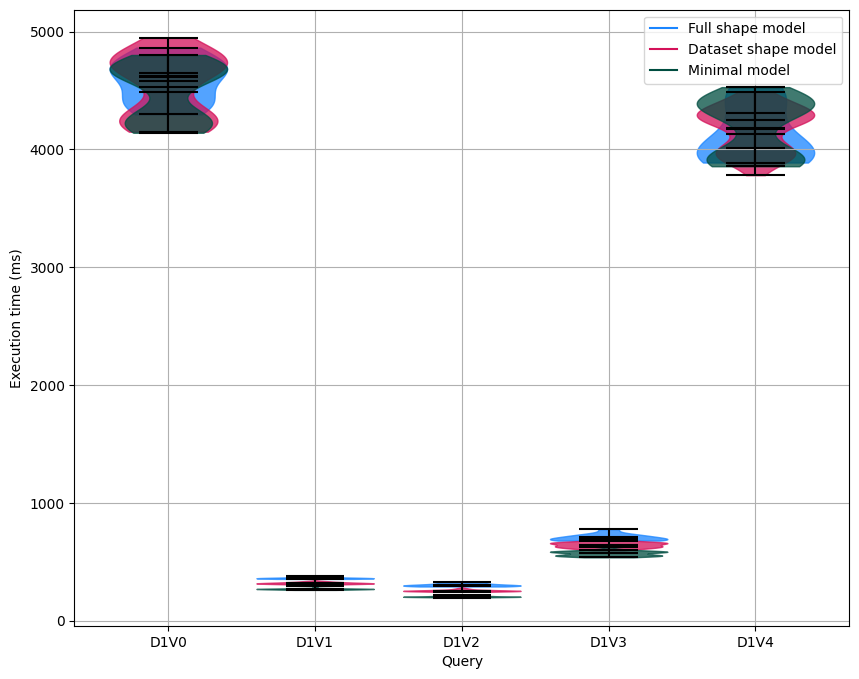

In [7]:
plotOneQueryExecutionTime(evalInstances,"interactive-discover-1", color_map)

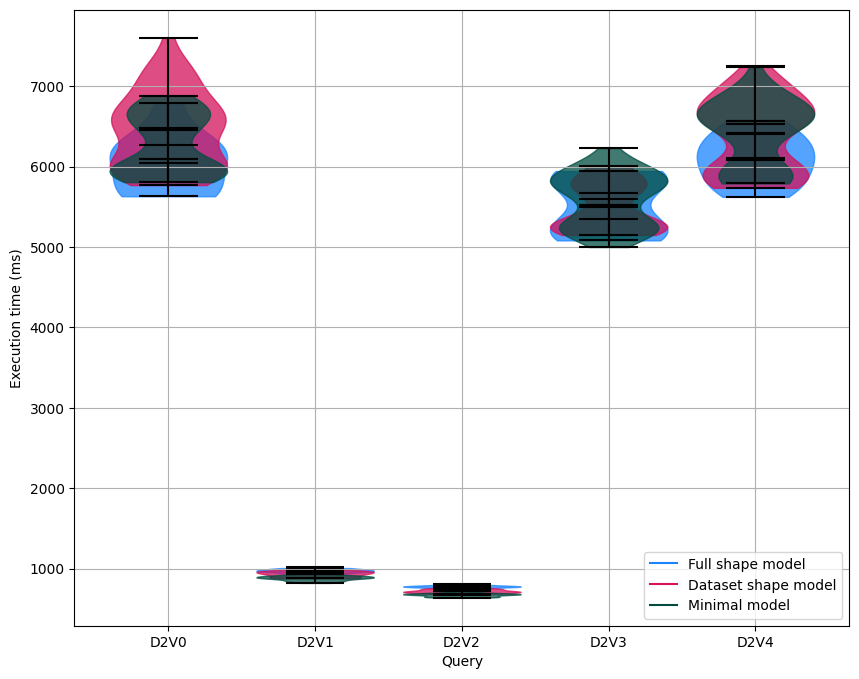

In [8]:
plotOneQueryExecutionTime(evalInstances,"interactive-discover-2", color_map)

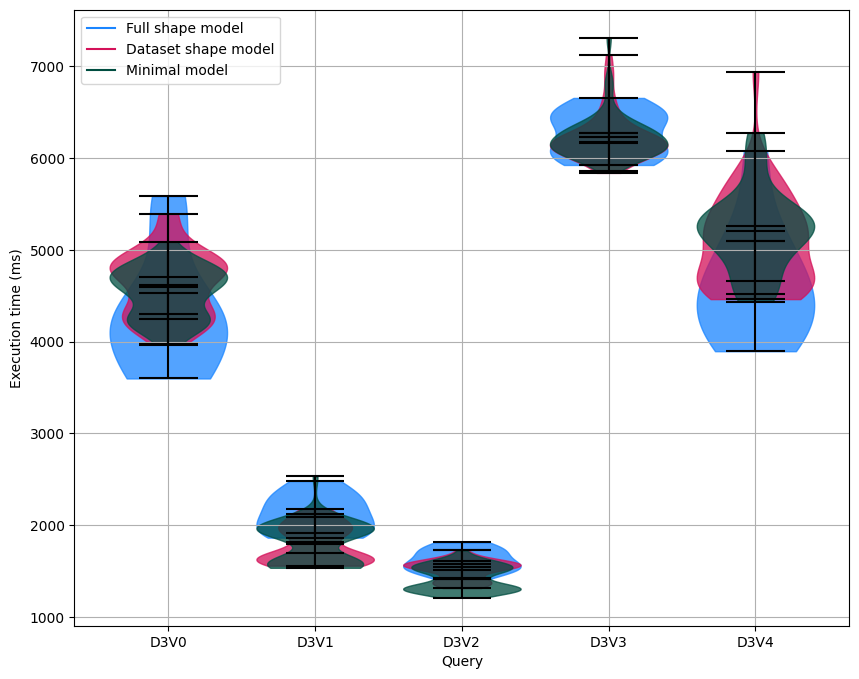

In [9]:
plotOneQueryExecutionTime(evalInstances,"interactive-discover-3", color_map)

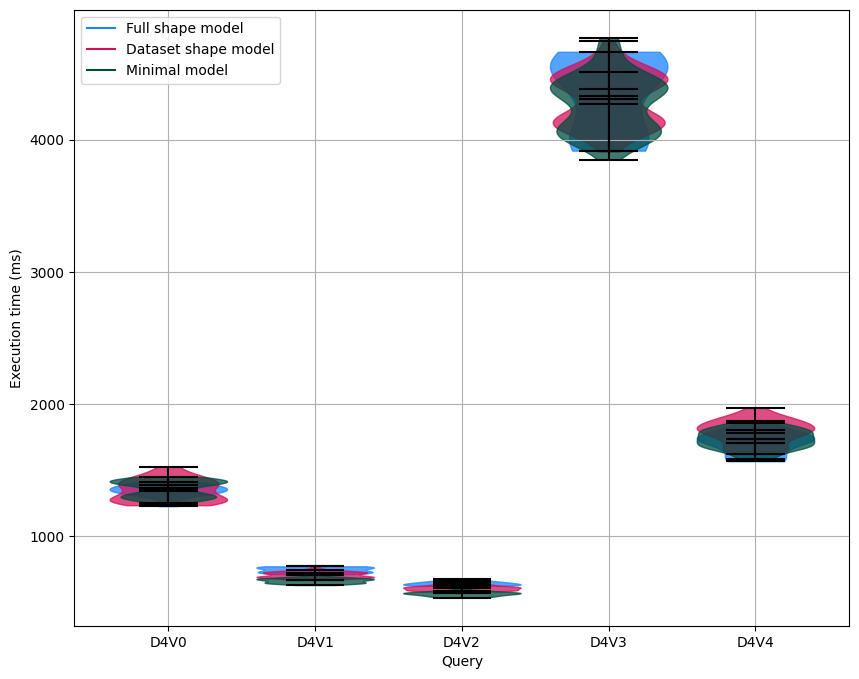

In [10]:
plotOneQueryExecutionTime(evalInstances,"interactive-discover-4", color_map)

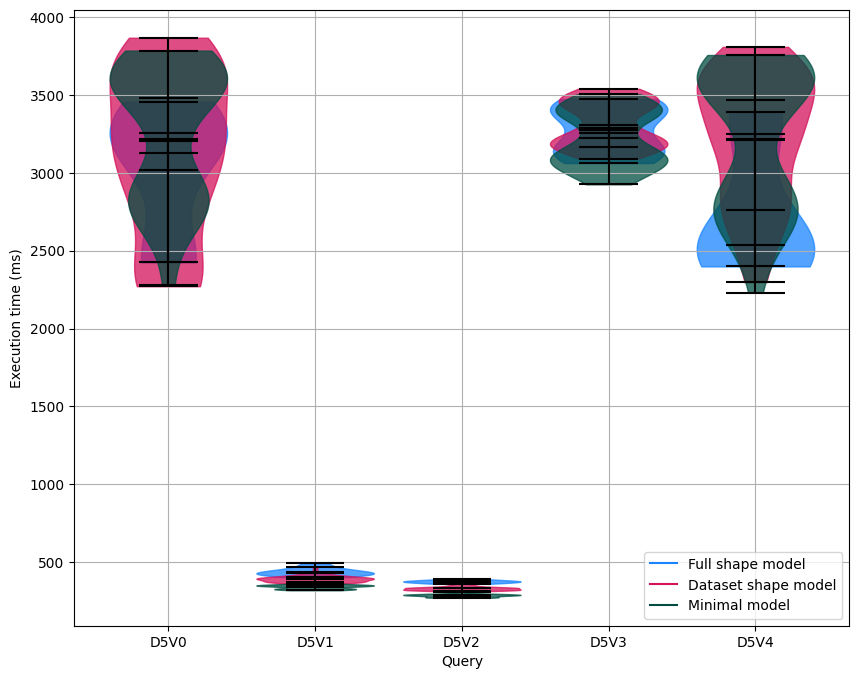

In [11]:
plotOneQueryExecutionTime(evalInstances,"interactive-discover-5", color_map)

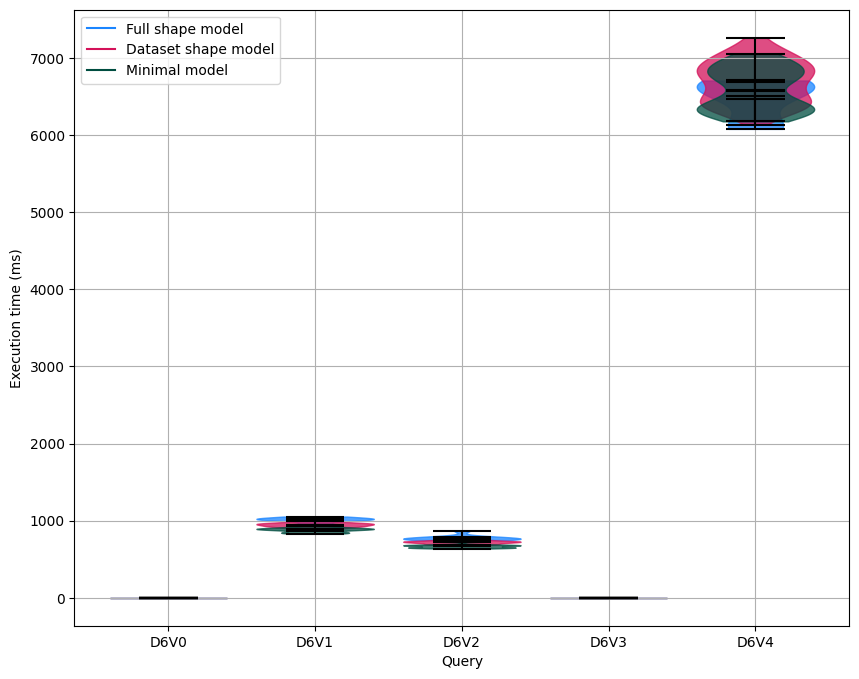

In [12]:
plotOneQueryExecutionTime(evalInstances,"interactive-discover-6", color_map)

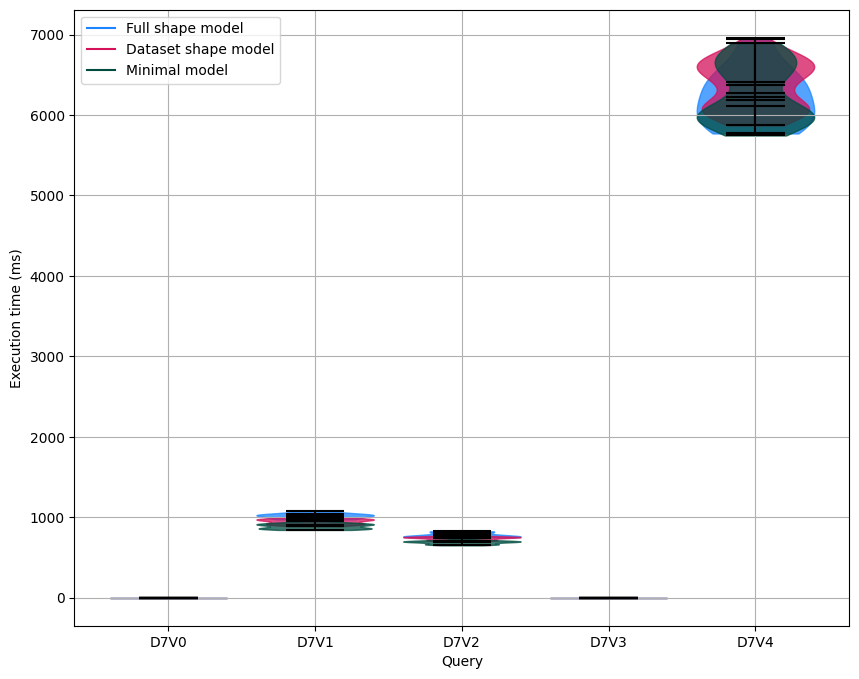

In [13]:
plotOneQueryExecutionTime(evalInstances,"interactive-discover-7", color_map)

### Short

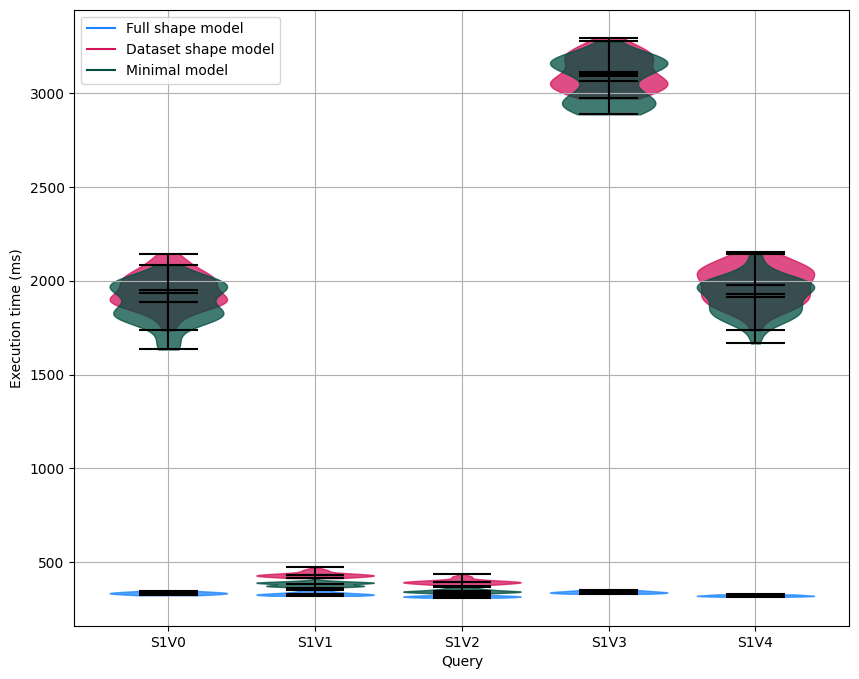

In [14]:
plotOneQueryExecutionTime(evalInstances,"interactive-short-1", color_map)

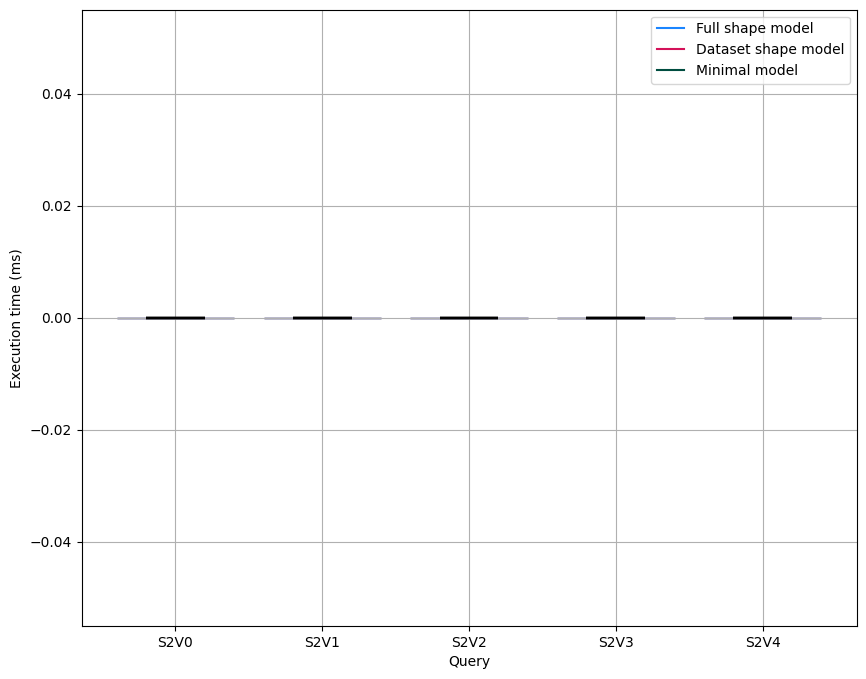

In [15]:
plotOneQueryExecutionTime(evalInstances,"interactive-short-2", color_map)

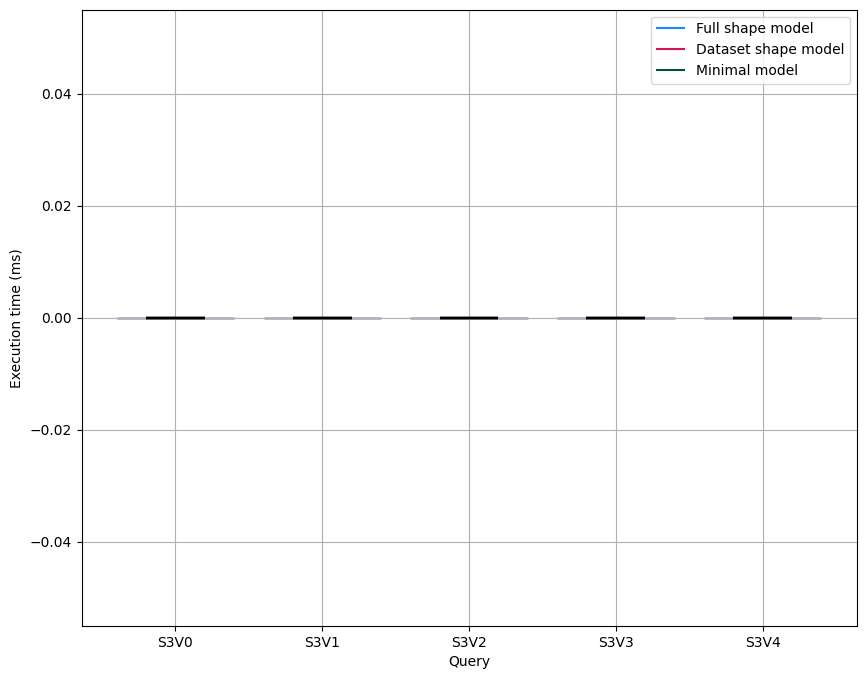

In [16]:
plotOneQueryExecutionTime(evalInstances,"interactive-short-3", color_map)

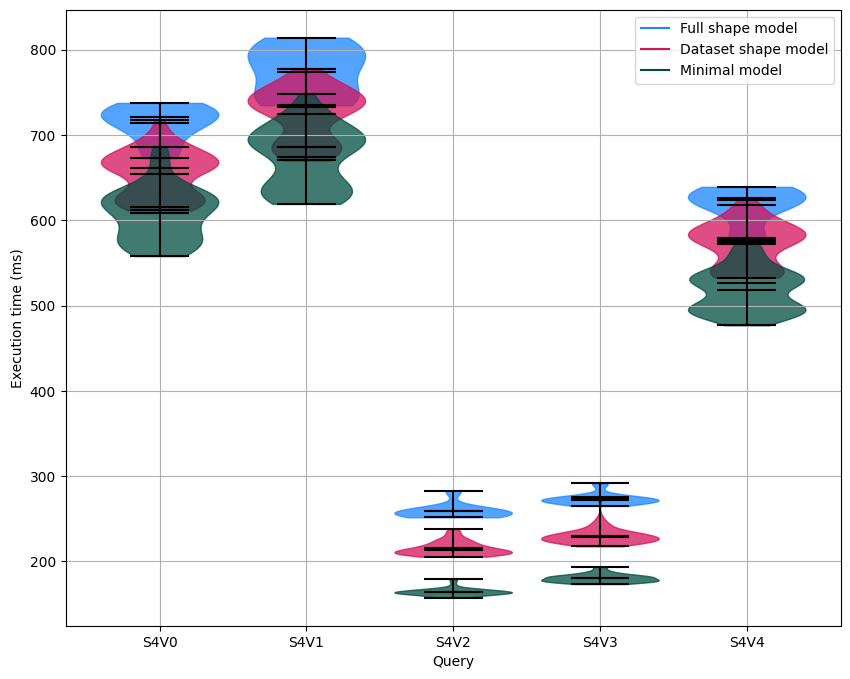

In [17]:
plotOneQueryExecutionTime(evalInstances,"interactive-short-4", color_map)

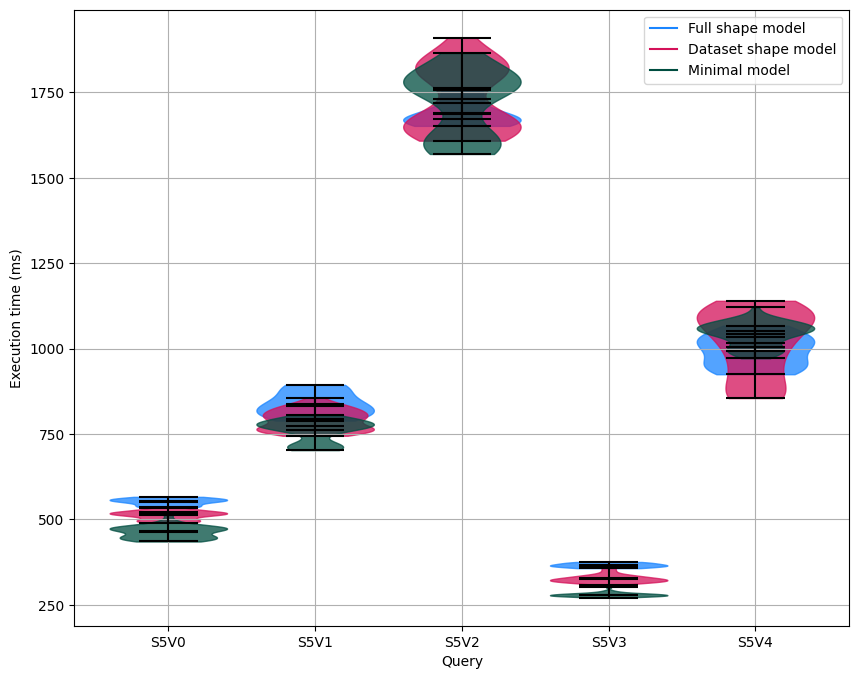

In [18]:
plotOneQueryExecutionTime(evalInstances,"interactive-short-5", color_map)

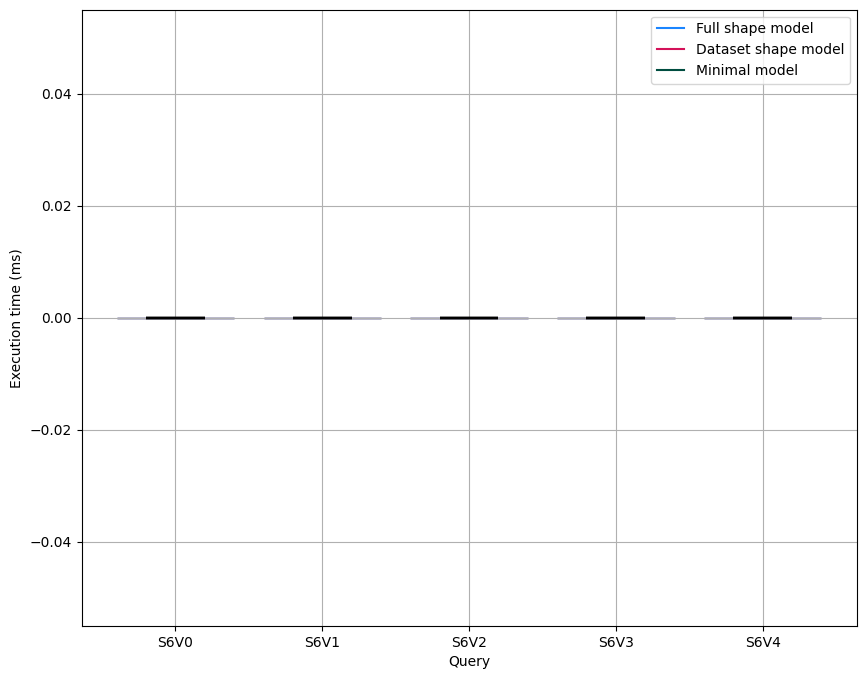

In [19]:
plotOneQueryExecutionTime(evalInstances,"interactive-short-6", color_map)

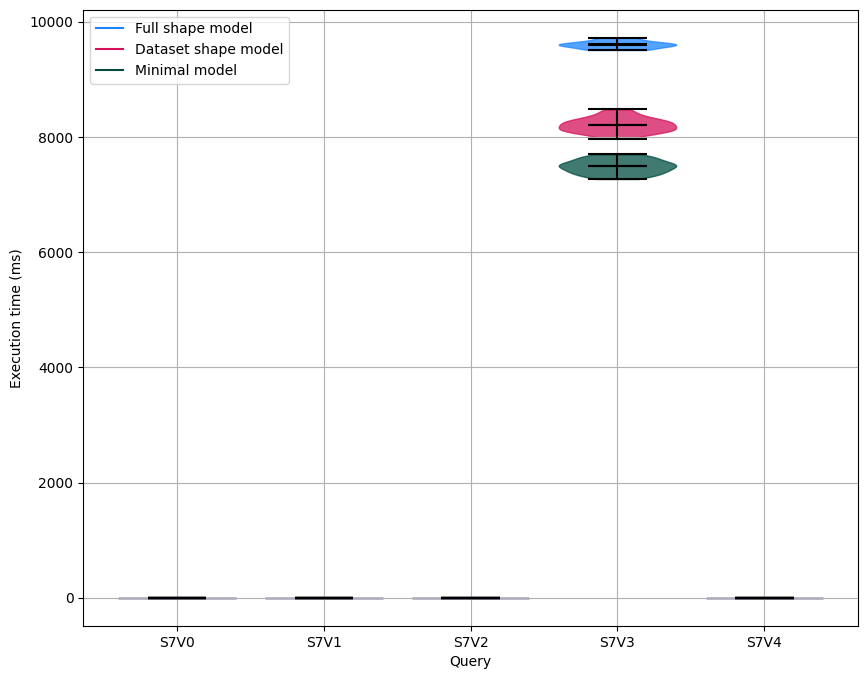

In [20]:
plotOneQueryExecutionTime(evalInstances,"interactive-short-7", color_map)

# Reduction by query templates

In [21]:
def statisticTemplateMetric(serie):
    stat = {}
    for query_template, val in serie.items():
        clean_list = list(filter(lambda a: a != None and a != -1, val))
        avg = np.nan
        std = np.nan
        min_val = np.nan
        max_val = np.nan
        if len(clean_list) !=0:
            avg = statistics.mean(clean_list)
            if len(clean_list) > 2:
                std = statistics.stdev(clean_list)
            min_val = min(clean_list)
            max_val = max(clean_list)
        stat[query_template] = {
            "avg": avg,
            "std": std,
            "min":min_val,
            "max": max_val
        }
    return stat

In [22]:
result_object = {}

In [23]:
instances = [shapeIndexInnerDataset, shapeIndexMinimalDataset]
for instance in instances:
    reduction_http_req = calculatePercentageReductionSeries(instance.numberHttpRequest, shapeIndexDataset.numberHttpRequest)
    reduction_time = calculatePercentageReductionSeries(instance.meanExecutionTime, shapeIndexDataset.meanExecutionTime)
    
    stat_http_req = statisticTemplateMetric(reduction_http_req)
    stat_time = statisticTemplateMetric(reduction_time)
    
    result_object[instance.name] = {
        "http_request": stat_http_req,
        "time": stat_time
    }

# Reduction by query templates figure

In [24]:
result_object_means_http = {}
result_object_means_time = {}
for instance, results in result_object.items():
    result_object_means_http[instance] = []
    result_object_means_time[instance] = []
    for key, values in results.items():
        if key=="time":
            for value in values.values():
                if value['avg'] == np.nan:
                   result_object_means_time[instance].append(0)
                else:
                    result_object_means_time[instance].append(value['avg'])
        if key=="http_request":
            for value in values.values():
                result_object_means_http[instance].append(value['avg'])
    

In [25]:
query_map = {
        "interactive-discover-1": "D1",
        "interactive-discover-2": "D2",
        "interactive-discover-3": "D3",
        "interactive-discover-4": "D4",
        "interactive-discover-5": "D5",
        "interactive-discover-6": "D6",
        "interactive-discover-7": "D7",
        "interactive-discover-8": "D8",
        "interactive-short-1": "S1",
        "interactive-short-2": "S2",
        "interactive-short-3": "S3",
        "interactive-short-4": "S4",
        "interactive-short-5": "S5",
        "interactive-short-6": "S6",
        "interactive-short-7": "S7"
    }

queries = query_map.values()

In [46]:
def generatePlot(results, yaxisLabel):
    
    x = np.arange(len(queries))
    width = 1/len(instances) -0.1 # the width of the bars
    multiplier = 0
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    for dataset, measurement in results.items():
        offset = width * multiplier + width/len(results)
        rects = ax.bar(x + offset, measurement, width, label=dataset)
        labels = [0 if x == 0 else "" for x in measurement]
        ax.bar_label(rects,labels=labels, padding=3)
        multiplier += 1
        
    ax.set_ylabel(yaxisLabel)
    ax.set_xticks(x + width, queries)
    ax.grid(axis="both")
    ax.legend()

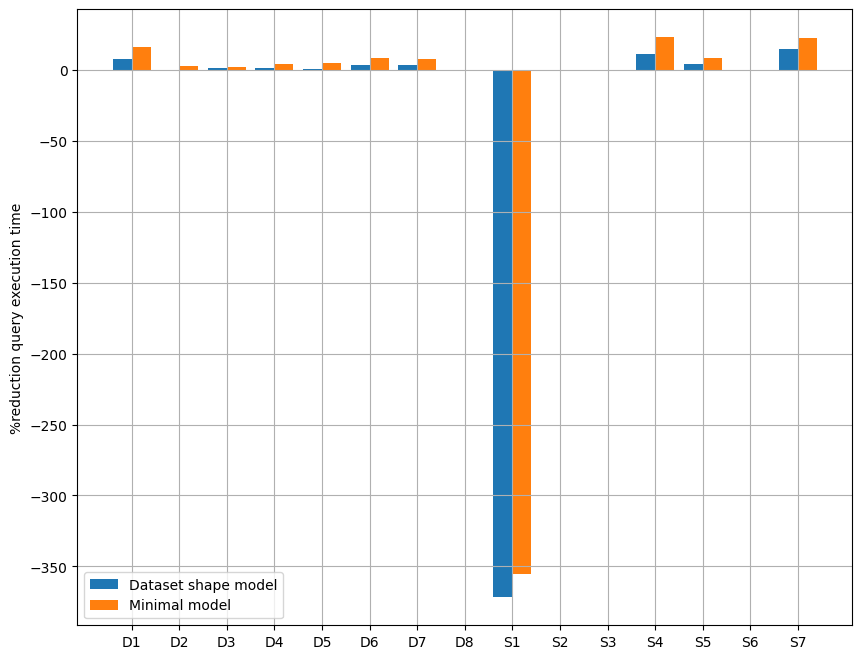

In [47]:
generatePlot(result_object_means_time,'%reduction query execution time')

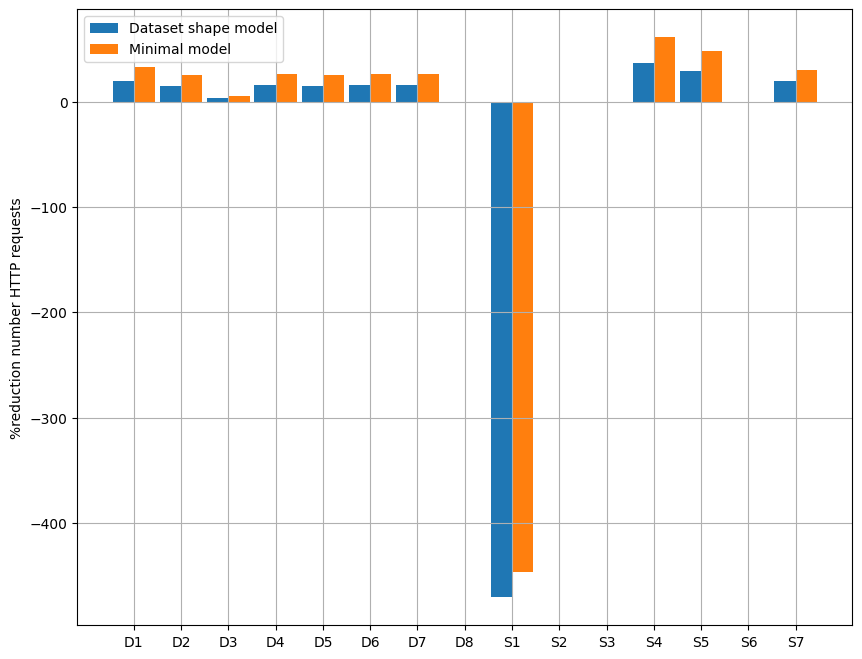

In [31]:
generatePlot(result_object_means_http,'%reduction number HTTP requests')